In [ ]:
pip install ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install ipynb

In [3]:
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from datetime import date
import glob, os
from joblib import dump, load
import xgboost as xgb
import time
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, balanced_accuracy_score
import random
random.seed(42)
from ipynb.fs.full.Data_Preparation import getProcessedData
from ipynb.fs.full.Data_Preparation import getFilenames

In [6]:
path = os.getcwd()

In [7]:
# Define the list of currency tickers used in the analysis
fx_tic = ['USDEUR',
            'USDJPY',
            'USDGBP',
            'USDCHF',
            'USDNZD',
            'USDCAD',
            'USDSEK',
            'USDDKK',
            'USDNOK',
            'EURJPY',
            'EURGBP',
            'EURCHF',
            'EURNZD',
            'EURCAD',
            'EURSEK',
            'EURDKK',
            'EURNOK']

# Create a dictionary that maps each currency ticker to an index
fx_dic = {'USDEUR': 0,
 'USDJPY': 1,
 'USDGBP': 2,
 'USDCHF': 3,
 'USDNZD': 4,
 'USDCAD': 5,
 'USDSEK': 6,
 'USDDKK': 7,
 'USDNOK': 8,
 'EURJPY': 9,
 'EURGBP': 10,
 'EURCHF': 11,
 'EURNZD': 12,
 'EURCAD': 13,
 'EURSEK': 14,
 'EURDKK': 15,
 'EURNOK': 16}

In [8]:
# Create a dictionary that defines the top 20 features for each currency ticker. These features are selected by SFFS
feat_20={
    'USDEUR': [0, 6, 11, 12, 16, 22, 23, 24, 25, 28, 30, 31, 33, 38, 44, 45, 48, 49, 54, 59],
    'USDJPY': [0, 13, 14, 15, 16, 18, 19, 20, 21, 22, 26, 28, 31, 33, 35, 38, 41, 47, 51, 53],
    'USDGBP': [1, 2, 5, 13, 16, 18, 23, 24, 25, 31, 35, 36, 38, 41, 42, 46, 48, 51, 52, 54],
    'USDCHF': [2, 5, 7, 8, 10, 11, 17, 25, 27, 35, 41, 43, 47, 48, 51, 52, 53, 54, 55, 57],
    'USDNZD': [5, 6, 8, 10, 13, 14, 17, 20, 21, 23, 24, 25, 33, 37, 40, 43, 51, 52, 53, 57],
    'USDCAD': [5, 8, 10, 11, 17, 18, 20, 23, 24, 25, 31, 33, 35, 40, 42, 52, 54, 55, 56, 57],
    'USDSEK': [7, 8, 10, 11, 17, 18, 21, 23, 24, 25, 26, 27, 31, 33, 35, 40, 42, 43, 53, 55],
    'USDDKK': [1, 3, 7, 13, 14, 17, 22, 23, 26, 27, 28, 29, 30, 31, 35, 44, 48, 51, 52, 53],
    'USDNOK': [0, 2, 4, 5, 7, 15, 17, 18, 20, 22, 23, 26, 27, 33, 34, 37, 47, 49, 51, 57],
    'EURJPY': [0, 1, 4, 9, 13, 20, 21, 23, 24, 25, 26, 29, 31, 41, 44, 47, 51, 53, 54, 56],
    'EURGBP': [4, 5, 7, 8, 13, 17, 18, 20, 21, 23, 24, 25, 27, 41, 42, 47, 51, 52, 54, 55],
    'EURCHF': [4, 11, 12, 14, 17, 18, 19, 26, 29, 32, 33, 34, 39, 40, 45, 47, 49, 50, 51, 52],
    'EURNZD': [8, 9, 10, 11, 16, 18, 21, 23, 26, 28, 31, 35, 36, 38, 46, 50, 51, 52, 53, 55],
    'EURCAD': [5, 8, 10, 11, 18, 20, 21, 23, 24, 25, 26, 28, 32, 33, 41, 42, 43, 46, 48, 58],
    'EURSEK': [2, 4, 8, 10, 11, 13, 15, 20, 22, 23, 33, 39, 40, 41, 44, 48, 51, 54, 55, 59],
    'EURDKK': [1, 6, 8, 10, 17, 21, 26, 30, 31, 35, 37, 43, 44, 45, 47, 48, 50, 51, 55, 58],
    'EURNOK': [2, 8, 10, 11, 13, 17, 18, 21, 23, 24, 25, 40, 41, 42, 43, 47, 53, 56, 57, 58]
}

In [9]:
def pfi(ticker_names):
    # List to store the result of permutation feature importance for each ticker
    pfi_result = []
    # Dictionary to store features for each ticker
    stock_columns = {}
    # List to store the indices of top 5 important features for each ticker
    pfi_result_top_5 = []

    # Get the number of available CPU cores for parallel processing
    n_cores = multiprocessing.cpu_count()

    # Loop through each ticker
    for i in range(len(ticker_names)):
        stock_name = ticker_names[i]
        
        # Data split
        X_train, X_val1, X_val2, X_test, y_train, y_val1, y_val2, y_test = getProcessedData(getFilenames(fx_tic)[fx_dic[stock_name]])
        # For each market, we only use top 20 features selected by SFFS.
        X_train = X_train.iloc[:,feat_20[stock_name]]
        X_val1 = X_val1.iloc[:,feat_20[stock_name]]
        X_val2 = X_val2.iloc[:,feat_20[stock_name]]
        X_test = X_test.iloc[:,feat_20[stock_name]]

        # Load the previously trained model with best hyperparameters for the current ticker
        xgb_model = load(path + '/model_weights/' + stock_name +'xgb.h5')

        # Store feature names for the current ticker
        stock_columns[stock_name] = X_train.columns

        # Compute the permutation feature importance on the validation set (val2)
        result = permutation_importance(xgb_model, X_val2, y_val2,
                                n_jobs=n_cores, n_repeats=5, random_state=42)

        # Append the permutation importance result to the results list
        pfi_result.append(result)
        # Sort feature importances in descending order and retain indices of the top 5 features
        feat_5 = np.argsort(result['importances_mean'])[::-1][:5]
        # Add the top 5 feature indices to the list
        pfi_result_top_5.append(feat_5)

    return pfi_result, stock_columns, pfi_result_top_5

In [12]:
start_time = time.time()
# Calculate and save the Permutation feature importance
pfi_result, stock_columns, pfi_result_top_5 = pfi(fx_tic)
end_time = time.time()
elapsed_time = end_time - start_time

[21:40:48] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[21:40:48] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[21:40:48] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, pl

In [13]:
print(f"The time cost of Permutation Feature Importance (PFI) is:{elapsed_time:.2f}s")

The time cost of Permutation Feature Importance (PFI) is:5.50s


In [14]:
pfi_result

[{'importances_mean': array([ 0.00717949,  0.00641026, -0.00794872,  0.00589744,  0.00051282,
          0.00974359,  0.00589744,  0.01205128,  0.01051282,  0.0025641 ,
          0.00205128, -0.01051282, -0.01      ,  0.        ,  0.00205128,
         -0.00230769, -0.00461538,  0.00153846, -0.00384615, -0.00179487]),
  'importances_std': array([0.00476951, 0.00850417, 0.00357138, 0.00418192, 0.00130744,
         0.00299023, 0.00448535, 0.00153846, 0.00558245, 0.00436651,
         0.00425981, 0.00357138, 0.00149512, 0.        , 0.00173906,
         0.00447067, 0.00433629, 0.005699  , 0.01149565, 0.00173906]),
  'importances': array([[ 0.00769231,  0.00384615,  0.01282051,  0.01153846,  0.        ],
         [ 0.01538462, -0.00512821, -0.0025641 ,  0.01282051,  0.01153846],
         [-0.00128205, -0.00769231, -0.00897436, -0.01153846, -0.01025641],
         [ 0.00128205,  0.01025641,  0.0025641 ,  0.01153846,  0.00384615],
         [ 0.        ,  0.0025641 ,  0.00128205, -0.00128205,  0. 

In [15]:
pfi_result_top_5

[array([7, 8, 5, 0, 1]),
 array([ 7, 18,  3, 16, 14]),
 array([18, 19,  3, 16, 15]),
 array([ 7, 10, 11, 12, 17]),
 array([ 6, 17, 18, 15,  8]),
 array([16,  3, 15, 13, 17]),
 array([ 1,  3, 14,  0, 12]),
 array([2, 3, 7, 6, 0]),
 array([ 2,  6,  0, 18, 11]),
 array([16, 10, 17,  9,  6]),
 array([15,  5,  1,  0,  7]),
 array([18,  3, 12, 17, 14]),
 array([ 9,  8, 11, 16,  7]),
 array([18, 16,  5,  1,  7]),
 array([ 1,  3, 16,  9, 10]),
 array([18,  4, 16, 17, 13]),
 array([11, 15, 14,  8, 13])]

In [16]:
# Dictionary to store the top 5 important features' names for each ticker
mkt_features = {}
j = 0
for key in stock_columns.keys():
    # Get indices of top 5 features for current ticker
    feat_5 = np.argsort(pfi_result[j]['importances_mean'])[::-1][:5]
    # Convert feature indices to feature names
    ls = [stock_columns[key][i] for i in feat_5]
    mkt_features[key] = ls
    j+=1

In [17]:
mkt_features

{'USDEUR': ['AROON_UP', 'AROONOSC', 'TRIMA', 'Open', 'Typical_Price'],
 'USDJPY': ['MOM', 'MI', 'BB_LB', 'RVGI', 'RVI'],
 'USDGBP': ['MSD', 'VORTEX_NEG', 'CCI', 'CHANDELIER_LONG', 'BBWIDTH'],
 'USDCHF': ['AROONOSC', 'RVGI', 'ATR', 'CHANDELIER_SHORT', 'VORTEX_NEG'],
 'USDNZD': ['DPO', 'MSD', 'TRIX', 'ATR', 'DX'],
 'USDCAD': ['VORTEX_NEG', 'ROC', 'MSD', 'CHOP', 'VORTEX_POS'],
 'USDSEK': ['SO', 'ROC', 'RVI', 'RSI', 'NATR'],
 'USDDKK': ['RSI', 'CCI', 'AROON_DOWN', 'TRIMA', 'High'],
 'USDNOK': ['Parabolic_SAR', 'DPO', 'Open', 'MI', 'ADX'],
 'EURJPY': ['MI', 'ADX', 'TRIX', 'AROONOSC', 'DX'],
 'EURGBP': ['CHANDELIER_SHORT',
  'DPO',
  'Coppock_Curve',
  'Parabolic_SAR',
  'MOM'],
 'EURCHF': ['MI', 'BB_HB', 'ACC_UP', 'KAMA', 'KC_LOWER'],
 'EURNZD': ['DEMA', 'ADX', 'RVI', 'MI', 'AROON_DOWN'],
 'EURCAD': ['CHANDELIER_LONG', 'ATR', 'MOM', 'SO', 'AROON_DOWN'],
 'EURSEK': ['Parabolic_SAR', 'WI', 'MI', 'AROON_DOWN', 'PSL'],
 'EURDKK': ['VORTEX_POS', 'DPO', 'KAMA', 'MI', 'KC_LOWER'],
 'EURNOK': ['CHO

In [18]:
# Dictionary to store mean importance for each feature of each ticker
ticker_imp = {}
for i in range(len(pfi_result)):
    ticker_imp[fx_tic[i]] = pfi_result[i]['importances_mean']

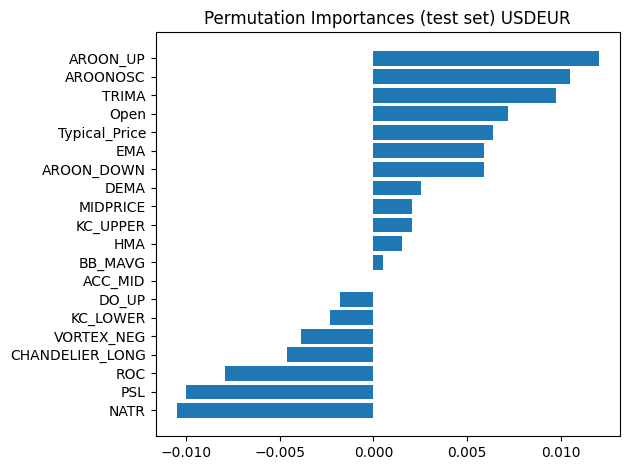

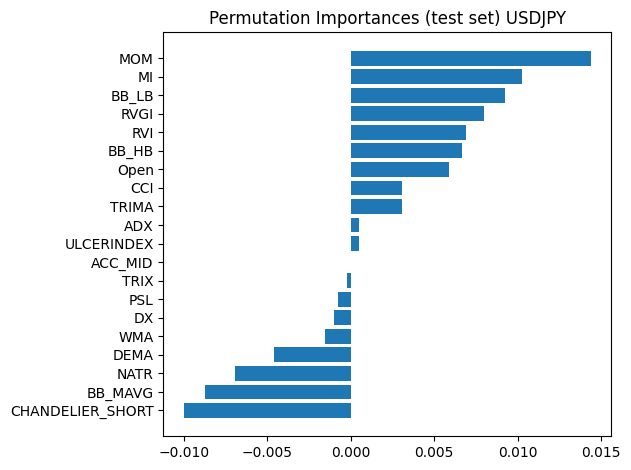

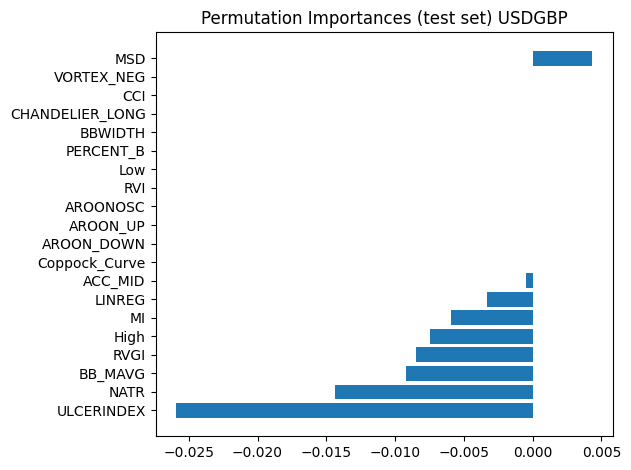

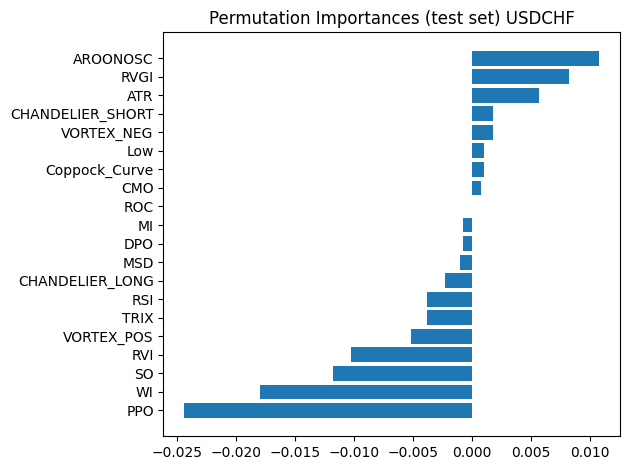

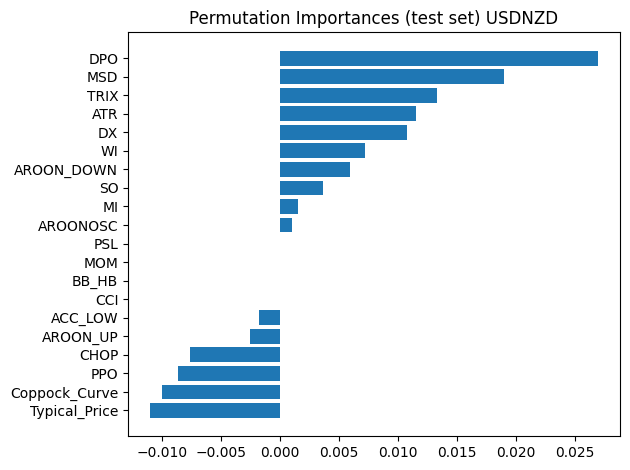

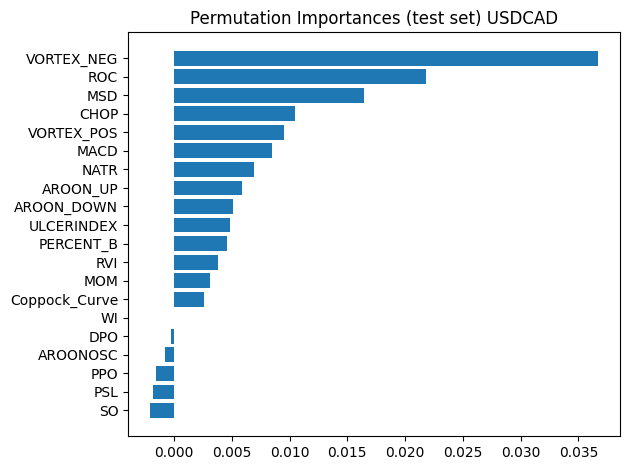

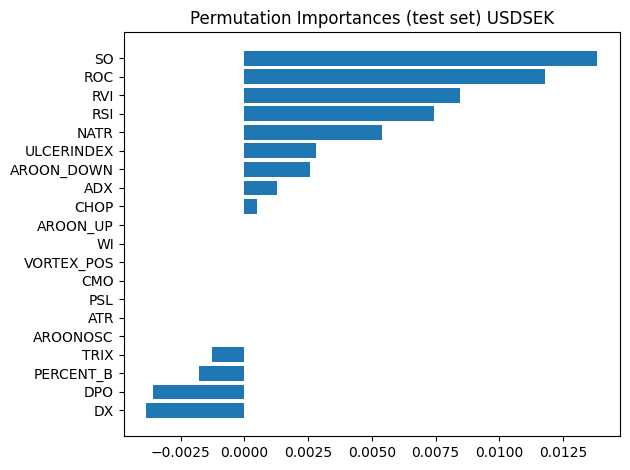

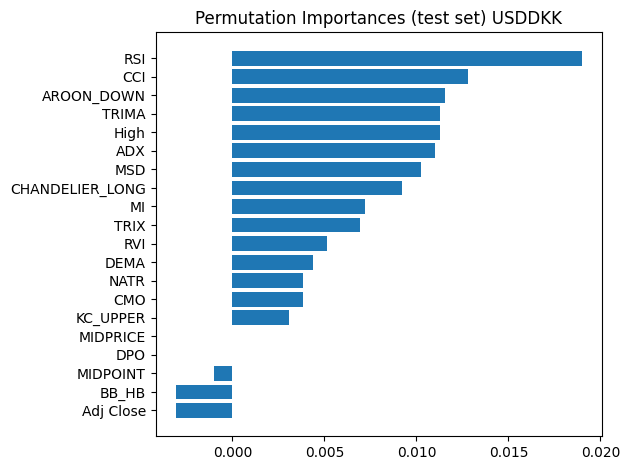

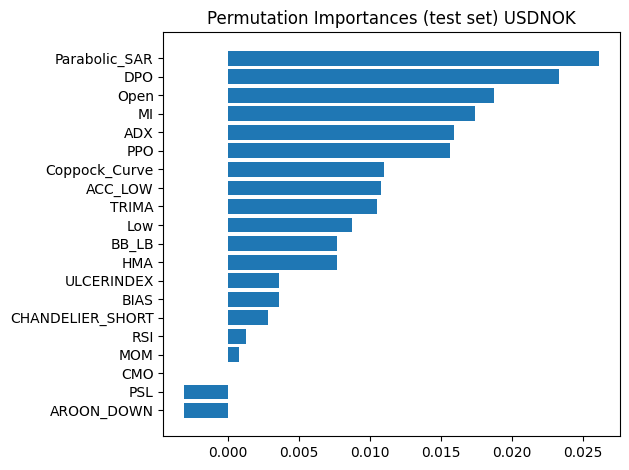

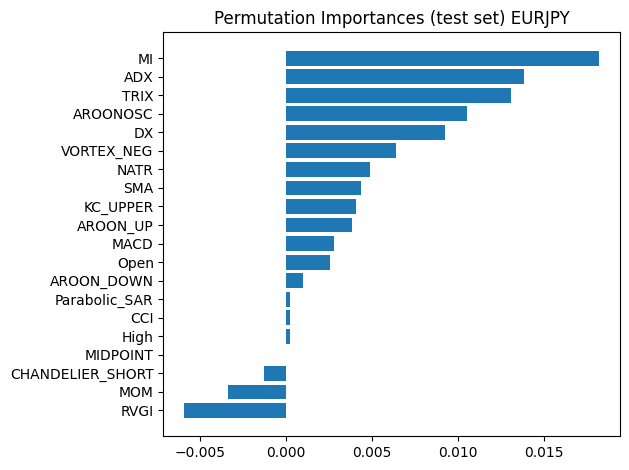

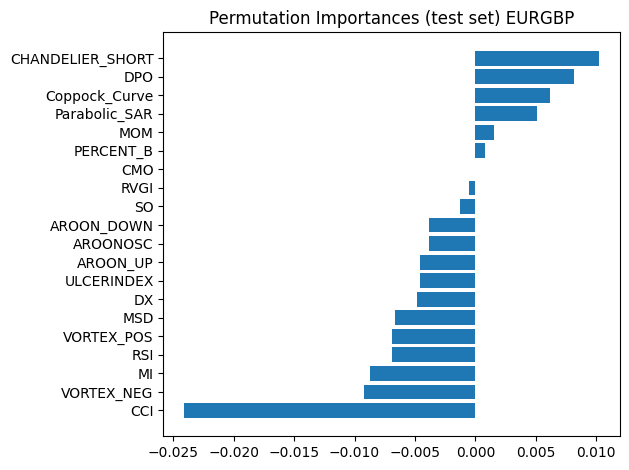

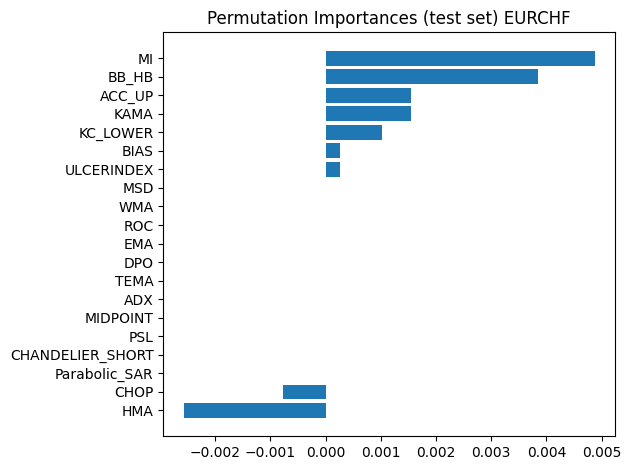

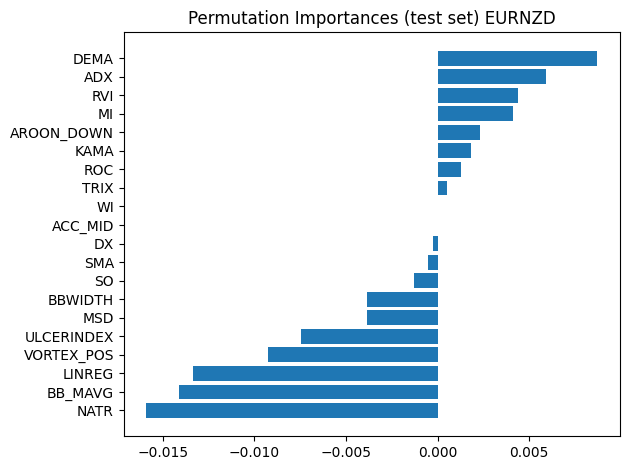

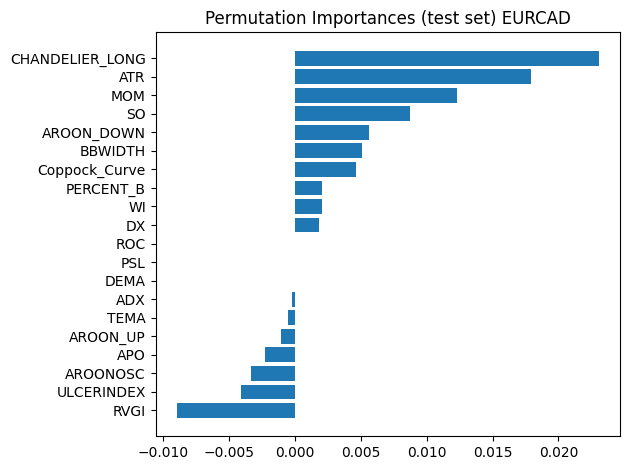

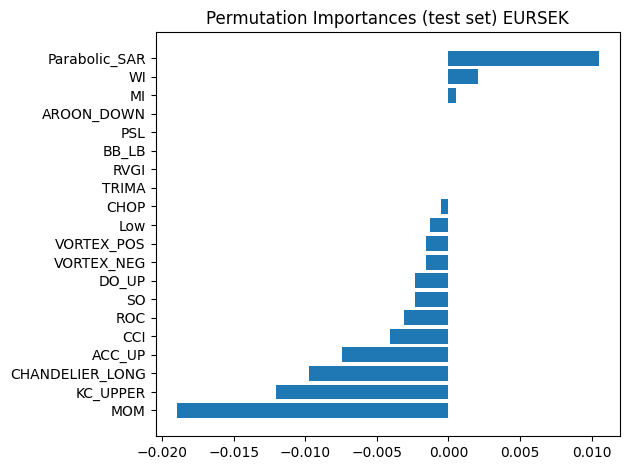

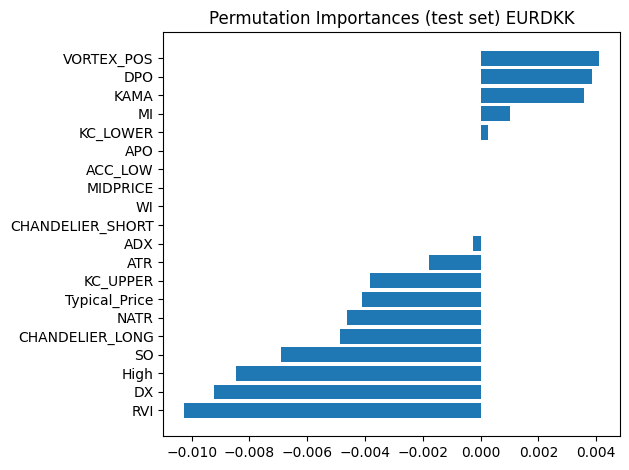

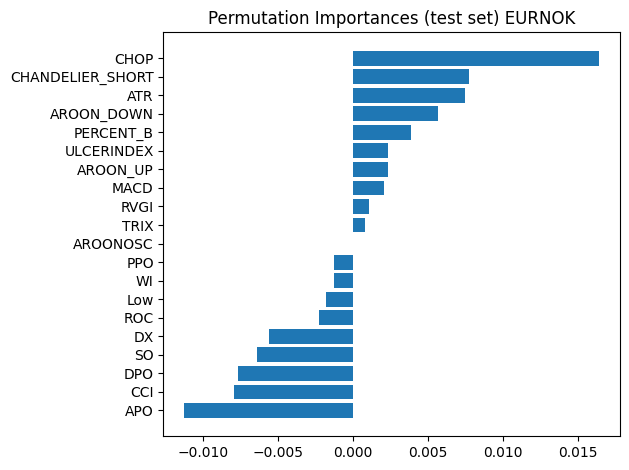

In [19]:
# Visualize the importance of each feature for each ticker
for i in range(len(pfi_result)):
    # Sort features by importance
    sorted_idx = ticker_imp[fx_tic[i]].argsort()

    # Plotting
    fig, ax = plt.subplots()
    ax.barh(stock_columns[fx_tic[i]][sorted_idx], pfi_result[i].importances[sorted_idx].mean(axis=1).T)
    ax.set_title("Permutation Importances (test set) "+fx_tic[i])
    fig.tight_layout()
    plt.show()

In [ ]:
# Save the complete feature importance results to a h5 file
dump(pfi_result, path + '/PFI_result/PFI_result.h5')

['/content/gdrive/MyDrive/Capstone-main/PFI_result/PFI_result.h5']

In [ ]:
# Save the top 5 features for each ticker to a h5 file
dump(mkt_features, path + '/PFI_result/PFI_Top_5.h5')

['/content/gdrive/MyDrive/Capstone-main/PFI_result/PFI_Top_5.h5']